In [1]:
import argparse, os
import cv2
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import nullcontext
from imwatermark import WatermarkEncoder
import torchvision.utils as vutils
import sys
from stereoutils import *
import matplotlib.pyplot as plt
%matplotlib inline
# sys.path.append('./stablediffusion')
# sys.path.append('./DPT')
from stablediffusion.ldm.util import instantiate_from_config
from stablediffusion.ldm.models.diffusion.ddim import DDIMSampler
from DPT.dpt.models import DPTDepthModel
%reload_ext autoreload
%autoreload 2

torch.set_grad_enabled(False)

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, device=torch.device("cuda"), verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    if device == torch.device("cuda"):
        model.cuda()
    elif device == torch.device("cpu"):
        model.cpu()
        model.cond_stage_model.device = "cpu"
    else:
        raise ValueError(f"Incorrect device name. Received: {device}")
    model.eval()
    return model

/home/lez/venvStereoDiffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--prompt",
    type=str,
    nargs="?",
    default="a professional photograph of an astronaut riding a triceratops",
    help="the prompt to render"
)
parser.add_argument(
    "--outdir",
    type=str,
    nargs="?",
    help="dir to write results to",
    default="outputs/txt2stereoimg-samples"
)
parser.add_argument(
    "--steps",
    type=int,
    default=50,
    help="number of ddim sampling steps",
)

parser.add_argument(
    "--ddim_eta",
    type=float,
    default=0.0,
    help="ddim eta (eta=0.0 corresponds to deterministic sampling",
)
parser.add_argument(
    "--n_iter",
    type=int,
    default=3,
    help="sample this often",
)
parser.add_argument(
    "--H",
    type=int,
    default=512,
    help="image height, in pixel space",
)
parser.add_argument(
    "--W",
    type=int,
    default=512,
    help="image width, in pixel space",
)
parser.add_argument(
    "--C",
    type=int,
    default=4,
    help="latent channels",
)
parser.add_argument(
    "--f",
    type=int,
    default=8,
    help="downsampling factor, most often 8 or 16",
)
parser.add_argument(
    "--n_samples",
    type=int,
    default=4,
    help="how many samples to produce for each given prompt. A.k.a batch size",
)

parser.add_argument(
    "--scale",
    type=float,
    default=9.0,
    help="unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))",
)
parser.add_argument(
    "--from-file",
    type=str,
    help="if specified, load prompts from this file, separated by newlines",
)
parser.add_argument(
    "--config",
    type=str,
    default="v2-infer-v.yaml",
    help="path to config which constructs model",
)
parser.add_argument(
    "--ckpt",
    type=str,
    help="path to checkpoint of model",
)
parser.add_argument(
    "--seed",
    type=int,
    default=24,
    help="the seed (for reproducible sampling)",
)

parser.add_argument(
    "--device",
    type=str,
    help="Device on which Stable Diffusion will be run",
    choices=["cpu", "cuda"],
    default="cuda"
)
parser.add_argument(
    "--direction",
    type=str,
    choices=["uni", "bi"],
    default="uni"
)

parser.add_argument(
    "--stereo_balance",
    type=int,
    choices=[-1,0],
    default=0
)

parser.add_argument(
    "--source_img",
    type=str,
    default=None,
    help="path to source image",
)
parser.add_argument("--depthmodel_path",type=str,required=True,help='path of depth model')


_StoreAction(option_strings=['--depthmodel_path'], dest='depthmodel_path', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help='path of depth model', metavar=None)

In [3]:
args = ["--ckpt", "models/v2-1_768-ema-pruned.ckpt",
        "--depthmodel_path","midas_models/dpt_hybrid-midas-501f0c75.pt",
        "--n_samples","2",
        # "--prompt","A young woman wearing with VR set, high definition, photo.",
        "--direction","uni"]
opt = parser.parse_args(args)

In [4]:
config = OmegaConf.load(f"{opt.config}")
device = torch.device("cuda") if opt.device == "cuda" else torch.device("cpu")
model = load_model_from_config(config, f"{opt.ckpt}", device)
sampler = DDIMSampler(model, device=device)
sampler2 = StereoShiftSampler(model, device=device)
depthmodel_path = opt.depthmodel_path
os.makedirs(opt.outdir, exist_ok=True)
batch_size = opt.n_samples if opt.source_img is None else 1

Loading model from models/v2-1_768-ema-pruned.ckpt


Global Step: 110000
No module 'xformers'. Proceeding without it.
LatentDiffusion: Running in v-prediction mode
DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [5]:
def infer(opt):
    with torch.no_grad():
        with model.ema_scope():
            seed_everything(opt.seed)
            depthmodel_path = 'midas_models/dpt_hybrid-midas-501f0c75.pt'
            # net_w = net_h = 384
            depthmodel = DPTDepthModel(path=depthmodel_path,backbone="vitb_rn50_384",non_negative=True,enable_attention_hooks=False,).cuda()
            prompts = opt.prompt
            sc1 = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)
            # sc2 = sc1.clone()
            start_code = torch.cat([sc1, sc1], dim=0)

            prompts = batch_size * [opt.prompt]
            uc = None
            if opt.scale != 1.0:
                uc = model.get_learned_conditioning(batch_size * [""])
            if isinstance(prompts, tuple):
                prompts = list(prompts)
            c = model.get_learned_conditioning(prompts)
            shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
            # restore_attention(model)
            samples1, _ = sampler.sample(S=opt.steps,
                                        conditioning=c,
                                        batch_size=opt.n_samples,
                                        shape=shape,
                                        verbose=False,
                                        unconditional_guidance_scale=opt.scale,
                                        unconditional_conditioning=uc,
                                        eta=opt.ddim_eta,
                                        x_T=start_code[:opt.n_samples])
            x_samples1 = model.decode_first_stage(samples1)
            x_samples1 = torch.clamp((x_samples1 + 1.0) / 2.0, min=0.0, max=1.0)
            # return rearrange(x_samples1,"b c h w -> c h (b w)")
            
            prediction = depthmodel.forward(x_samples1)

            sa = 10
            editor = BNAttention(start_step=sa,direction=opt.direction)
            regiter_attention_editor_diffusers(model, editor)   
            samples2, _ = sampler2.sample(S=opt.steps,
                                        conditioning=torch.concat([c,c],0),
                                        batch_size=opt.n_samples*2,
                                        shape=shape,
                                        verbose=False,
                                        unconditional_guidance_scale=opt.scale,
                                        unconditional_conditioning=torch.concat([uc,uc],0),
                                        eta=opt.ddim_eta,
                                        x_T=start_code,disparity=prediction,swapat=sa,
                                        shift_both=opt.shift_both,deblur=opt.deblur)
            x_samples2 = model.decode_first_stage(samples2)
            x_samples2 = torch.clamp((x_samples2 + 1.0) / 2.0, min=0.0, max=1.0)
            output = rearrange_img(x_samples2)
            output = rearrange(output,"b c h w -> c h (b w)")
    return output

Global seed set to 2023


Data shape for DDIM sampling is (2, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


10
Data shape for DDIM sampling is (4, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


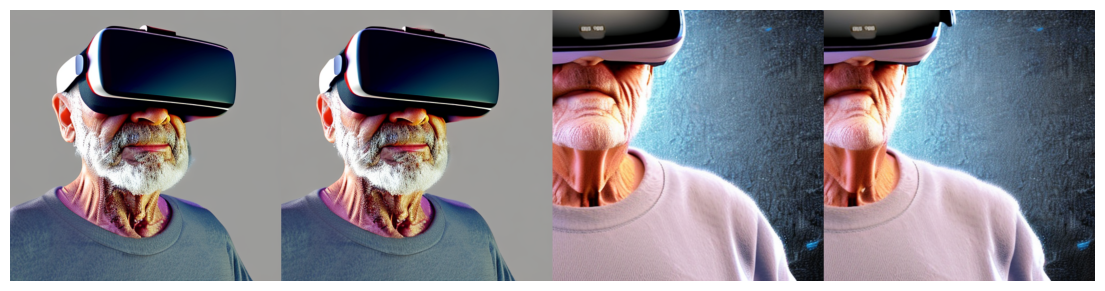

In [7]:
sampler2 = StereoShiftSampler(model, device=device)
opt.direction = 'uni'
opt.shift_both = False
opt.deblur = False
opt.seed = 2023
opt.prompt = 'An old man wearing VR set, high definition, photorealistic.'
output = infer(opt)
image = output.cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(14,7))
plt.imshow(image)
plt.axis('off')
plt.show()